In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## (1) Exploration

In [55]:
trades = pd.read_csv("sample_trades (1).csv", index_col = 0)
trades

,buysell,datetime,exchange,filled_prx,filled_qty,symbol,symbol_base
0,BUY,00:00.8,XXX,2440.70,1.50000,ETHUSDT.XXX,ETH
1,BUY,00:00.8,XXX,2440.70,1.30000,ETHUSDT.XXX,ETH
2,BUY,00:00.8,XXX,2440.70,0.90000,ETHUSDT.XXX,ETH
3,BUY,00:00.8,XXX,2440.70,1.40000,ETHUSDT.XXX,ETH
4,BUY,00:00.8,XXX,2440.70,0.80000,ETHUSDT.XXX,ETH
...,...,...,...,...,...,...,...
49176,SELL,59:59.6,XXX,164.86,6.90000,SOLUSDT.XXX,SOL
49177,SELL,59:59.6,XXX,164.86,0.50000,SOLUSDT.XXX,SOL
49178,SELL,59:59.6,XXX,164.86,0.60000,SOLUSDT.XXX,SOL
49179,SELL,59:59.7,XXX,2440.38,0.02690,ETHUSD.XXX,ETH


In [56]:
trades.loc[:, ["symbol", "symbol_base"]].value_counts()

symbol       symbol_base
ETHUSD.XXX   ETH            9924
ETHUSDT.XXX  ETH            9608
SOLUSD.XXX   SOL            6658
SOLUSDT.XXX  SOL            6068
BTCUSD.XXX   BTC            5768
BTCUSDT.XXX  BTC            5767
XRPUSD.XXX   XRP            2332
XRPUSDT.XXX  XRP            1553
ETHUSDT.YYY  ETH             996
BTCUSDT.YYY  BTC             507
Name: count, dtype: int64

### Minor data processing

In [57]:
# Convert datetime into integer deci-seconds
trades.loc[:, "datetime"] = trades.loc[:, "datetime"].str.extract(r'.(.)').values.flatten().astype(int) + trades.loc[:, "datetime"].str.extract(r':(.{2})').values.flatten().astype(int) * 10 + trades.loc[:, "datetime"].str.extract(r'(.{2}):').values.flatten().astype(int) * 60 * 10
# Group trades done on the same ds
trades = trades.groupby(["datetime", "buysell", "symbol_base"]).agg({
    "filled_qty": "sum",
    "filled_prx": lambda x: np.average(x, weights = trades.loc[x.index, "filled_qty"])
}).reset_index()

### Splitting data by symbol base

In [58]:
dfs = {symbase : trades[trades.loc[:, "symbol_base"] == symbase] for symbase in trades.loc[:, "symbol_base"].unique()}

## (2) Calculating trade metrics

The calculation ignores the difference in exchange and USD/USDT differences, since the task requested summary per base symbol.

In [114]:
def calc_trade_metrics(df):
    # Initialize variables
    position = 0
    profit = 0
    avg_price = 0
    first_trade = True

    cashflow = list()
    positions = list()
    profits = list()
    notional_values = list()
    avg_prices = list()

    # trade by trade
    for i, row in df.iterrows():
        # BUY
        if row.loc["buysell"] == "BUY":
            # Update change to cashflow
            cash_change = -1 * row.loc["filled_prx"] * row.loc["filled_qty"]

            # Update position
            og_position = position
            position += row.loc["filled_qty"]

            # If add to position -> avg_price changes, profit is zero
            if og_position >= 0:
                avg_price = (avg_price * abs(og_position) + row.loc["filled_prx"] * row.loc["filled_qty"]) / abs(position)
                profit = None
            # If reduce position
            else:
                # If position flipped from short to long -> close out the short position, create a long position
                if position >= 0:
                    profit = (avg_price - row.loc["filled_prx"]) * abs(og_position)
                    avg_price = row.loc["filled_prx"] if position != 0 else 0
                # If position still short -> pnl is realized, avg_price does not change
                else:
                    profit = (avg_price - row.loc["filled_prx"]) * row.loc["filled_qty"]
        # SELL
        else:
            # Update change to cashflow
            cash_change = 1 * row.loc["filled_prx"] * row.loc["filled_qty"]

            # Update position
            og_position = position
            position -= row.loc["filled_qty"]

            # If add to position -> avg_price changes, profit is zero
            if og_position <= 0:
                avg_price = (avg_price * abs(og_position) + row.loc["filled_prx"] * row.loc["filled_qty"]) / abs(position)
                profit = None
            
            # If reduce position
            else:
                # If position flipped from long to short -> close out the long position, create a short position
                if position <= 0:
                    profit = (row.loc["filled_prx"] - avg_price) * abs(og_position)
                    avg_price = row.loc["filled_prx"] if position != 0 else 0
                # If position still long -> pnl is realized, avg_price does not change
                else:
                    profit = (row.loc["filled_prx"] - avg_price) * row.loc["filled_qty"]
        
        # First trade profit is zero
        if first_trade:
            first_trade = False
            profit = None
        
        # Save the cashflow, positions, profits, and notional values
        avg_prices.append(avg_price)
        cashflow.append(cash_change)
        positions.append(position)
        profits.append(profit)
        notional_values.append(position * row.loc["filled_prx"])
    
    ## TO SUMMARIZE RESULTS

    # Metadata, handle the last row
    index = df.loc[:, "datetime"].tolist() + [df.loc[:, "datetime"].iloc[-1]]
    buysell = df.loc[:, "buysell"].tolist() + ["BUY" if notional_values[-1] < 0 else "SELL"]
    filled_qty = df.loc[:, "filled_qty"].tolist() + [abs(positions[-1])]
    filled_prx = df.loc[:, "filled_prx"].tolist() + [row.loc["filled_prx"]]

    # Handle the last row where position is closed at (assuming at the final traded price)
    cashflow.append(notional_values[-1])
    positions.append(0)
    profits.append((row.loc["filled_prx"] - avg_price) * position if position > 0 else (avg_price - row.loc["filled_prx"]) * abs(position))
    notional_values.append(0)
    avg_prices.append(0)

    # Summarize results into a DataFrame
    result = pd.DataFrame({
        "index" : index,
        "minute" : [x // (10 * 60) for x in index],
        "buysell": buysell,
        "filled_qty": filled_qty,
        "filled_prx": filled_prx,
        "cashflow": cashflow,
        "cum_cashflow": np.cumsum(cashflow),
        "positions": positions,
        "avg_prices": avg_prices,
        "profits": profits,
        "cum_profits": np.cumsum(np.where(pd.isnull(profits), 0, profits).astype(float)),
        "notional_values": notional_values
    }).set_index("index")

    return result


In [115]:
results = {symbase : calc_trade_metrics(dfs[symbase]) for symbase in dfs.keys()}

In [116]:
results["BTC"]

,minute,buysell,filled_qty,filled_prx,cashflow,cum_cashflow,positions,avg_prices,profits,cum_profits,notional_values
index,,,,,,,,,,,
0,0,BUY,0.50000,66694.090000,-33347.045000,-33347.045000,0.50000,66694.090000,NaN,0.000000,33347.045000
0,0,SELL,0.00074,66690.450000,49.350933,-33297.694067,0.49926,66694.090000,-0.002694,-0.002694,33295.874067
50,0,SELL,0.14228,66688.010000,9488.370063,-23809.324004,0.35698,66694.090000,-0.865062,-0.867756,23806.285810
60,0,SELL,1.59483,66682.697146,106347.565890,82538.241886,-1.23785,66682.697146,-4.067021,-4.934777,-82543.176663
70,0,BUY,0.50000,66691.990000,-33345.995000,49192.246886,-0.73785,66682.697146,-4.646427,-9.581204,-49208.684821
...,...,...,...,...,...,...,...,...,...,...,...
35919,59,BUY,0.00067,66730.720000,-44.709582,11541.327046,-0.32693,66686.868031,-0.029381,-10260.610719,-21816.274290
35929,59,SELL,0.05619,66730.730000,3749.599719,15290.926765,-0.38312,66693.301013,NaN,-10260.610719,-25565.877278
35969,59,SELL,0.40197,66635.990000,26785.668900,42076.595665,-0.78509,66663.957488,NaN,-10260.610719,-52315.249389


## (3) Analyse Results - Types of Trades

Generally, for each base symbol, there are specific filled quantity sizes that occur significantly more than sizes similar to it.

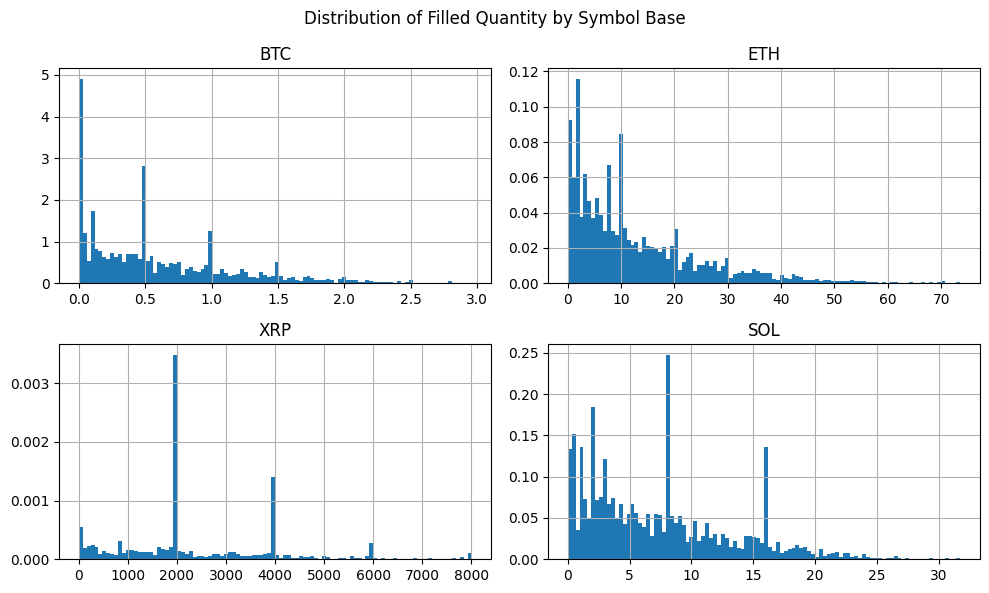

In [117]:
fig, ax = plt.subplots(2, 2, figsize = (10, 6))

for i, symbase in enumerate(results.keys()):
    ax_ = ax[i // 2, i % 2]
    ax_.hist(results[symbase].loc[:, "filled_qty"], bins = 100, density = True, label = symbase)
    ax_.set_title(symbase)
    ax_.grid()
fig.suptitle("Distribution of Filled Quantity by Symbol Base")
fig.tight_layout()

The filled quantity of each base symbol for buy and sell are very similar through time. Indicating that most trades are designed to be of very short term. This hints that potentially, the active position of each base symbol hovers close to zero through time.

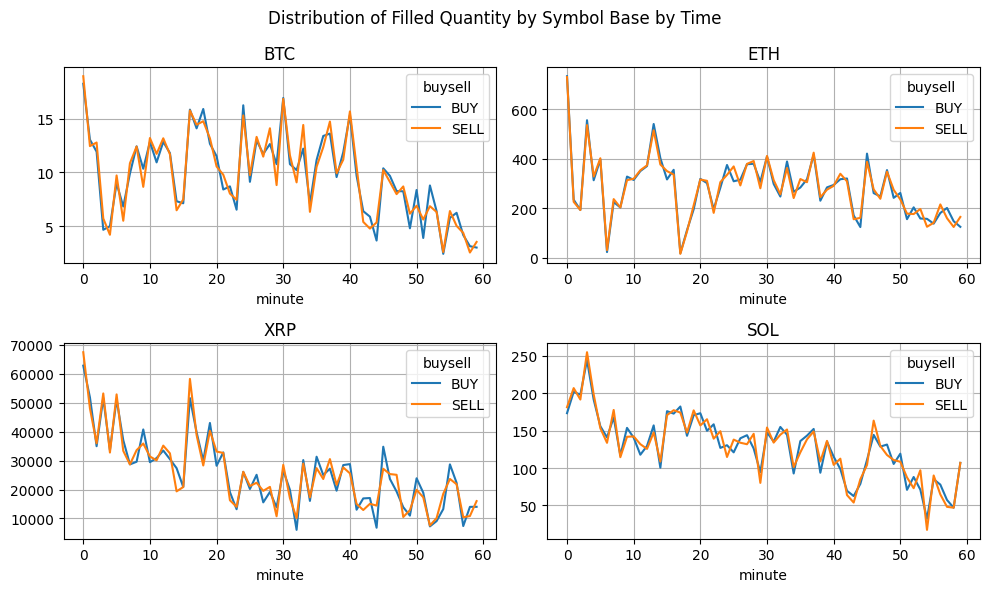

In [118]:
fig, ax = plt.subplots(2, 2, figsize = (10, 6))

for i, symbase in enumerate(results.keys()):
    ax_ = ax[i // 2, i % 2]
    results[symbase].groupby(["minute", "buysell"]).agg({"filled_qty": "sum"}).reset_index().pivot(index = "minute", columns = "buysell", values = "filled_qty").plot(kind = "line", grid = True, ax = ax_)
    ax_.set_title(symbase)
fig.suptitle("Distribution of Filled Quantity by Symbol Base by Time")
fig.tight_layout()

## 4. Analyse Results - Trade Metrics

### (a) P&L

Majority of the trades ended in a lost for all base symbols.  
And all base symbols ended in an overall loss.

In [155]:
pd.DataFrame({symbase : pd.concat((results[symbase].loc[:, "profits"].describe(), pd.Series([results[symbase].loc[:, "profits"].sum()], index = ["sum"]))) for symbase in results.keys()})

,BTC,ETH,XRP,SOL
count,1185.000000,1667.000000,862.000000,1051.000000
mean,-8.706119,-6.978981,-0.327266,-0.443365
std,23.498785,15.955546,0.758642,1.053285
min,-225.487824,-130.451135,-4.520871,-7.302328
25%,-16.083318,-11.938109,-0.683022,-0.740055
50%,-1.625491,-2.556341,-0.123032,-0.139737
75%,1.653217,0.935960,0.071585,0.152946
max,62.660184,36.105194,1.388008,1.808931
sum,-10316.751005,-11633.961645,-282.102980,-465.976456


Distribution of profits in each trade generally seem to have more values on the negative side. Histograms generally seem to skew to the left.

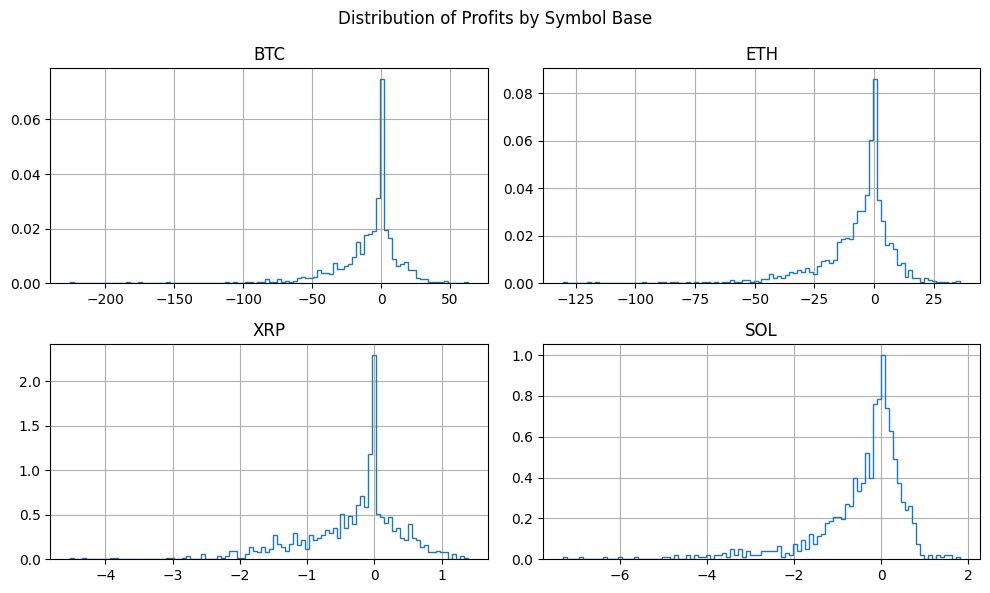

In [123]:
fig, ax = plt.subplots(2, 2, figsize = (10, 6))
max_val = max([np.max(results[symbase].loc[:, "profits"].abs()) for symbase in results.keys()])

for i, symbase in enumerate(results.keys()):
    ax_ = ax[i // 2, i % 2]
    ax_.hist(results[symbase].loc[:, "profits"], bins = 100, histtype = "step", density = True, label = symbase)
    ax_.set_title(symbase)
    ax_.grid()
fig.suptitle("Distribution of Profits by Symbol Base")
fig.tight_layout()

Plotting accumulated profits through time, it seems that for all 4 base symbol, the accumulated profits are consistently on a down trend.

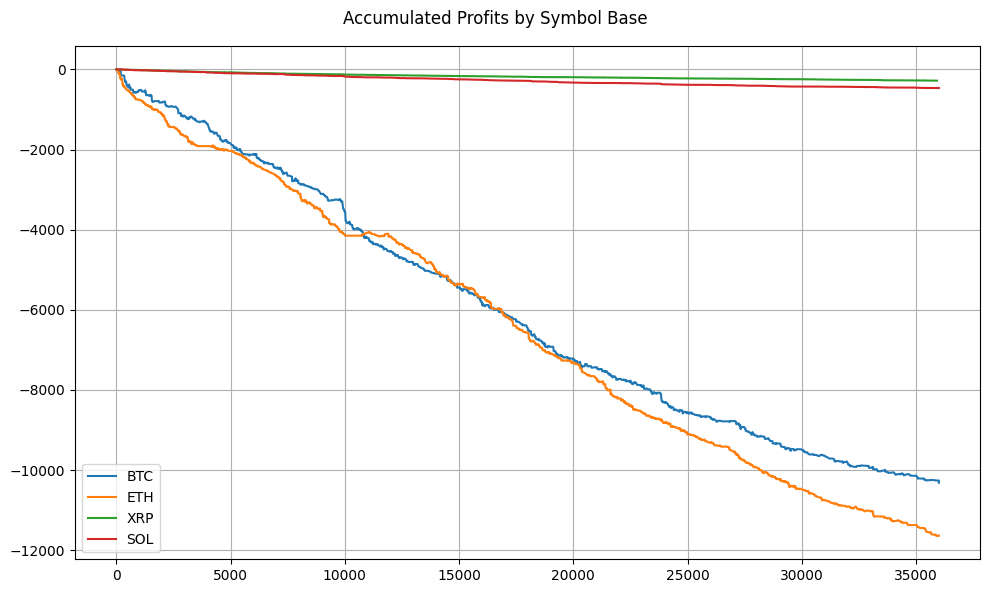

In [124]:
fig, ax_ = plt.subplots(1, 1, figsize = (10, 6))

for i, symbase in enumerate(results.keys()):
    ax_.plot(results[symbase].loc[:, "cum_profits"], label = symbase)
ax_.legend()
ax_.grid()
fig.suptitle("Accumulated Profits by Symbol Base")
fig.tight_layout()

### (b) Notional Value

In [158]:
pd.DataFrame({symbase : pd.concat((results[symbase].loc[:, "notional_values"].describe(), pd.Series([results[symbase].loc[:, "notional_values"].iloc[-2]], index = ["last"]))) for symbase in results.keys()})

,BTC,ETH,XRP,SOL
count,1940.000000,2694.000000,1276.000000,2121.000000
mean,-51673.332692,35257.625222,-263.280426,-2433.289984
std,58681.959780,42702.676900,1286.903624,1385.376480
min,-207083.715189,-83719.900328,-2354.758980,-5306.560000
25%,-96621.593870,3532.114271,-1320.708105,-3545.299890
50%,-49040.214734,34189.868248,-319.293480,-2293.491339
75%,-6358.959813,67631.465328,705.752091,-1396.591900
max,103459.804484,202398.850755,3080.471790,1550.410921
last,-100483.590520,-22346.315622,-2181.558750,-4518.600286


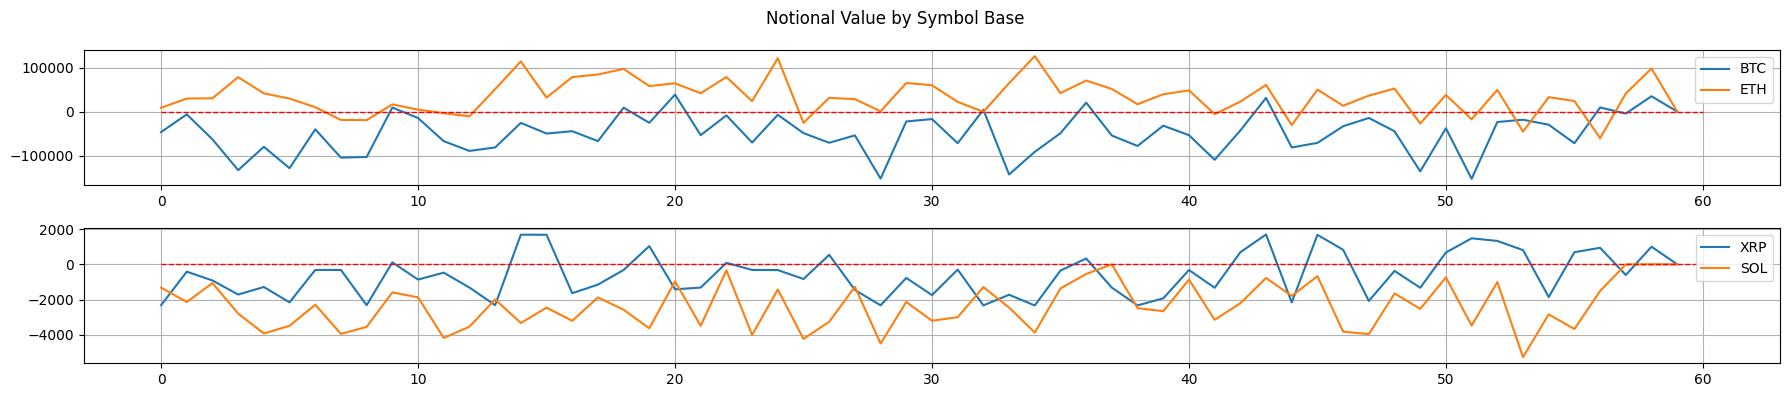

In [145]:
fig, ax = plt.subplots(2, 1, figsize = (18, 4))

for i, symbase in enumerate(results.keys()):
    ax_ = ax[0] if results[symbase].loc[:, "notional_values"].abs().mean() > 10_000 else ax[1]
    ax_.plot(
        results[symbase].groupby(["minute"]).agg({"notional_values": "last"}), label = symbase
    )
ax[0].hlines(0, xmin = 0, xmax = 60, color = 'red', linestyle = '--', linewidth = 1)
ax[1].hlines(0, xmin = 0, xmax = 60, color = 'red', linestyle = '--', linewidth = 1)
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
fig.suptitle("Notional Value by Symbol Base")
fig.tight_layout()

As suggested by the notional values curves, XRP, SOL and BTC are generally more commonly held in a net short position, while ETH are generally held net long.

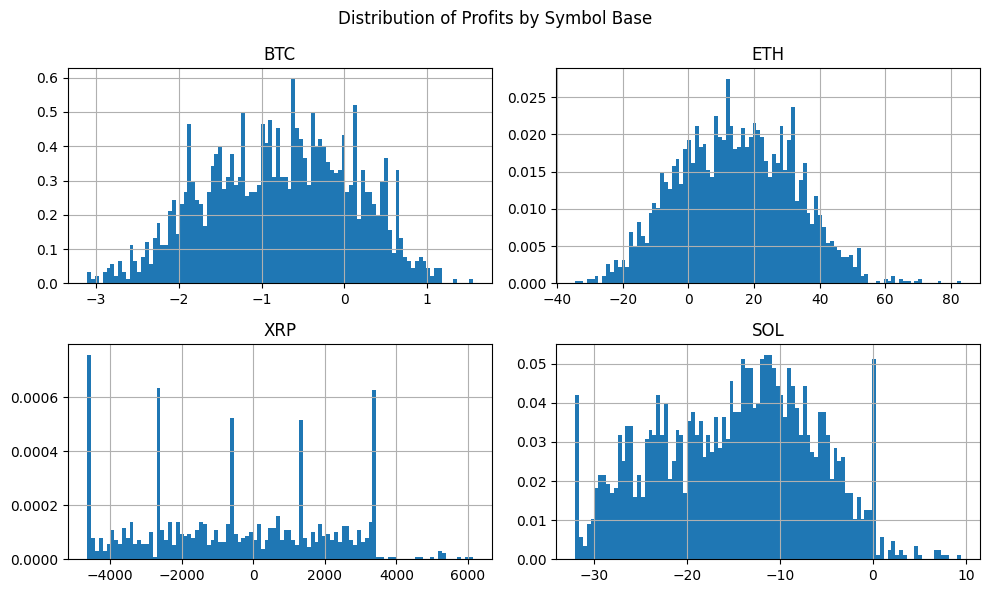

In [141]:
fig, ax = plt.subplots(2, 2, figsize = (10, 6))
max_val = max([np.max(results[symbase].loc[:, "profits"].abs()) for symbase in results.keys()])

for i, symbase in enumerate(results.keys()):
    ax_ = ax[i // 2, i % 2]
    ax_.hist(results[symbase].loc[:, "positions"], bins = 100, density = True, label = symbase)
    ax_.set_title(symbase)
    ax_.grid()
fig.suptitle("Distribution of Profits by Symbol Base")
fig.tight_layout()

## (4) Conclusion

In [186]:
from scipy.stats import chisquare, mood

In [ ]:
print("Chisquare test for profits by base symbol, assuming H_0: profits are equally likely to be positive or negative")
for symbase in results.keys():
    print(f"p-value for {symbase} : {round(chisquare((results[symbase].profits > 0).value_counts().values, 2 * [len(results[symbase].profits > 0) / 2]).pvalue, 3)}")
    

Chisquare test for profits by base symbol, assuming H_0: profits are equally likely to be positive or negative
p-value for BTC : 0.0
p-value for ETH : 0.0
p-value for XRP : 0.0
p-value for SOL : 0.0


In [190]:
pos = results[symbase].profits[results[symbase].profits > 0]
neg = results[symbase].profits[results[symbase].profits < 0].abs()

print("Mood's median test for profits by base symbol, assuming H_0: profits median of profits and losses are equal vs H_1: profits median of profits are smaller than of losses")
for symbase in results.keys():
    print(f"p-value for {symbase} : {round(mood(pos, neg, alternative = "less").pvalue, 3)}")

Mood's median test for profits by base symbol, assuming H_0: profits median of profits and losses are equal vs H_1: profits median of profits are smaller than of losses
p-value for BTC : 0.0
p-value for ETH : 0.0
p-value for XRP : 0.0
p-value for SOL : 0.0


In [208]:
print("Ascending Ranking of base symbols by total profits and mean absolute notional value")
pd.DataFrame({symbase : (results[symbase].profits.sum(), results[symbase].notional_values.abs().mean()) for symbase in results.keys()}).rename(index = {0: "total profits", 1: "mean abs notional value"}).T.rank(method = "min")

Ascending Ranking of base symbols by total profits and mean absolute notional value


,total profits,mean abs notional value
BTC,2.0,4.0
ETH,1.0,3.0
XRP,4.0,1.0
SOL,3.0,2.0


From the above analyses:
1. It is statistically-significant at a significance level of 0.1%, that the profits are more likely to be negative.
2. It is also statistically-significant at a significance level of 0.1%, that the median of profits are smaller than the median of losses.
3. The base symbol with the smallest losses is XRP, followed by SOL, but that is likely because the traded value (represented by mean absolute notional value) for these two are generally small.